In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual, GridspecLayout
import ipywidgets as widgets
from IPython.display import display

In [3]:
# define some plotting functions
colours = {"ground_truth": "#4daf4a",
           "empirical": "#f781bf",
           "exact": "#377eb8",
           "approx": "#ff7f00",
           "prior": "#a65628"}
linestyles = {"ground_truth": "solid",
              "empirical": "dashdot",
              "exact": "dashed",
              "approx": "dotted",
              "prior": (0, (3, 5, 1, 5, 1, 5))}

def get_contours(x, mu, std):
    return (1 / (std * np.sqrt(np.pi))) * np.exp(-0.5 * np.square((x - mu) / std))

def plot_contours(ax, *args):
    for arg in args:
        x, y, c, l, ls = arg
        ax.plot(x, y, color=c, linestyle=ls, label=l)
        ax.legend(loc='upper right')

# Bayesian Inference

This tutorial accompanies the "Introduction to Bayesian Inference" video in the NMedIA "Essentials of Medical Imaging Analysis" course. Bayesian inference is commonly used in modelling scenarios. The idea of this tutorial is to allow you to adjust different parameters in a problem where Bayesian inference is used for model fitting. We hope this will help you build intuition and assist you if you come across algorithms using Bayesian inference in practice.

# Example Scenario

Like all good tutorials, we'll assume our data was generated from a Normal distribution. Our goal is to estimate the parameters of the Normal distribution from which our data was sampled, i.e. the mean and standard deviation.

## Sample some data

Below, we sample some data from a 1-dimensional Normal distribution and plot their histogram. Feel free to play with the value of the mean, $\mu$, and the standard deviation, $\sigma$, and see how this changes the data.

Things to note/try:
* For large values of $N$, you should see the typical bell-curve shape of the Normal distribution.
* If you change $\mu$, the centre of the data will move (i.e. the centre value on the $x$ axis will move).
* If you increase $\sigma$, the spread of the data will increase (i.e. the range on the $x$ axis will increase).

<IPython.core.display.Javascript object>


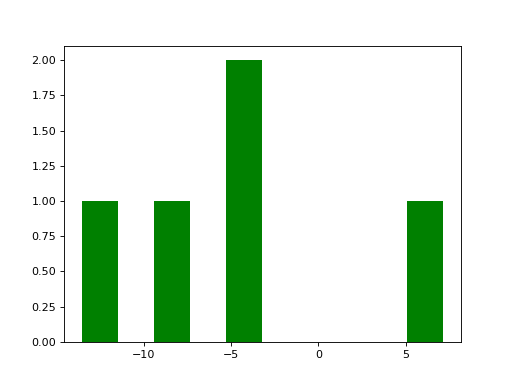

interactive(children=(IntSlider(value=50, continuous_update=False, description='N', max=500, min=5, step=5), I…

In [4]:
def get_data(N, mu, std):
    w.value = np.random.normal(mu, std, [N])

def display_data(ax, data):
    ax.hist(w.value, bins=10, color='g', align='left')
    plt.show()
    
def update_plot(change):
    ax0.clear()
    display_data(ax0, data=w.value)

# set up figure
fig0, ax0 = plt.subplots(num=0)

# get our widgets
N = widgets.IntSlider(value=50, min=5, max=500, step=5, description="N", continuous_update=False)
mu = widgets.IntSlider(value=0, min=-10, max=10, step=1, description="$\mu$", continuous_update=False)
std = widgets.FloatSlider(value=1., min=0.1, max=10, step=0.1, description="$\sigma$", continuous_update=False)

w = interactive(get_data, N=N, mu=mu, std=std);
display(w);

# display our data
display_data(ax0, w.value);

# watch for a change in our widgets. This is messy, is there a nicer way to do it?
[w.children[n].observe(update_plot, 'value') for n in range(len(w.children))];

# Empirical Mean and Standard Deviation

The first thing we might think to do is simply get the mean and the standard deviation of our observations.

If you play around with the values of the parameters $N$, $\mu$ and $\sigma$ you should notice:
* Increasing the number of observations, $N$, drives our empirical approximation closer to the ground truth;
* Similarly, deacreasing the standard deviation, $\sigma$, of our distribution generally results in a better approximation;
* If we have a small number of observations, $N$, and a large standard deviation, $\sigma$, our empirical approximation can be quite poor!

interactive(children=(IntSlider(value=50, continuous_update=False, description='N', max=500, min=5, step=5), I…

<IPython.core.display.Javascript object>


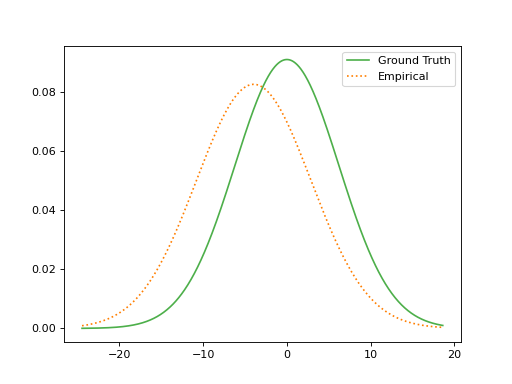

In [5]:
def update_empirical_contour(change):
    emp_mean, emp_std = [np.mean(w.value), np.std(w.value)]
    xmin = np.min((mu.value-3*std.value, emp_mean-3*emp_std))
    xmax = np.max((mu.value+3*std.value, emp_mean+3*emp_std))
    x = np.linspace(xmin, xmax, 1000)
    data_contour = get_contours(x, mu.value, std.value)
    emp_contour = get_contours(x, emp_mean, emp_std)
    ax1.clear()
    plot_contours(ax1,
                  (x, data_contour, colours["ground_truth"], "Ground Truth", linestyles["ground_truth"]),
                  (x, emp_contour, colours["approx"], "Empirical", linestyles["approx"]))

emp_mean, emp_std = [np.mean(w.value), np.std(w.value)]
display(w);

fig1, ax1 = plt.subplots(num=1)
xmin = np.min((mu.value-3*std.value, emp_mean-3*emp_std))
xmax = np.max((mu.value+3*std.value, emp_mean+3*emp_std))
x = np.linspace(xmin, xmax, 1000)
data_contour = get_contours(x, mu.value, std.value)
emp_contour = get_contours(x, emp_mean, emp_std)
plot_contours(ax1,
              (x, data_contour, colours["ground_truth"], "Ground Truth", linestyles["ground_truth"]),
              (x, emp_contour, colours["approx"], "Empirical", linestyles["approx"]))
[w.children[n].observe(update_empirical_contour, 'value') for n in range(len(w.children))];

# Bayesian Inference

Suppose we also want to express our confidence in our parameter estimates, i.e. how confident are we in our estimate of the mean, $\mu$? The simple method above can't do this. It only gives us estimates of $\mu$ and $\sigma$. It also doesn't let us include prior knowledge about the ground truth distribution.

If you aren't familiar with probability or feel like you could be doing with a refresher, don't worry! The aim of this section is to give you some intuition into the different parts of a Bayesian model, not to be able to reproduce the code below. You should play around with the values used in the model via the sliders and watch how this changes the solution. This will hopefully make you more comfortable when reading about methods using Bayesian models - these pop up very frequently in medical image analysis!

## Set up our prior

Bayesian inference allows us to include any prior information we have about the distribution which generated our observations. This can be very helpful in two situations in particular:
* When we don't have many observations;
* When our observations are very noisy.

Michael mentions in the video that a criticism of priors in Bayesian inference is that it can bias the results we get. We'll see how this can happen below and how we can diagnose it.

In the following model, we have 4 parameters. These are:
* $m_0$ = Our prior knowledge of the mean;
* $v_0$ = Our prior confidence in our prior mean;
* $\beta_0$ = Our prior on the mean of the variance;
* $\sigma_0$ = How confident we are in our prior on the variance.

Our uncertainty about our prior's mean is shown by the dashed lines. These have been drawn at $m_0 \pm2v_0$. The default setting of the prior where $v_0 = 1000$ reflects the fact that we are highly uncertain about our prior value on the mean.

<IPython.core.display.Javascript object>


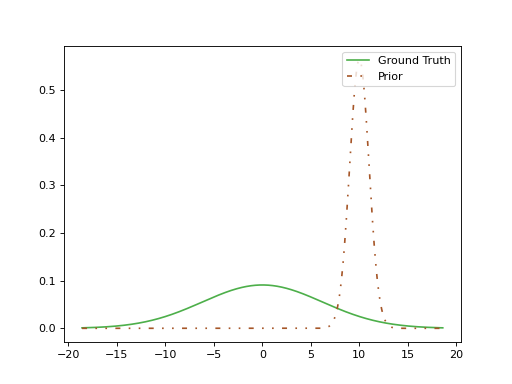

GridspecLayout(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='N', m…

In [6]:
def print_prior(m0, v0, beta_mean0, beta_var0):
    print(m0, v0, beta_mean0, beta_var0)

def update_prior_contour(change):
    xmin = np.min((m0.value-3*beta_mean0.value, mu.value-3*std.value))
    xmax = np.max((m0.value+3*beta_mean0.value, mu.value+3*std.value))
    x = np.linspace(xmin, xmax, 1000)
    data_contour = get_contours(x, mu.value, std.value)
    prior_contour = get_contours(x, m0.value, beta_mean0.value)
    ax2.clear()
    plot_contours(ax2,
                  (x, data_contour, colours["ground_truth"], "Ground Truth", linestyles["ground_truth"]),
                  (x, prior_contour, colours["prior"], "Prior", linestyles["prior"]))

# create widgets for the prior values of our NormalGamma distribution
m0 = widgets.IntSlider(value=0, min=-10, max=10, step=1, description="$m_0$", continuous_update=False)
v0 = widgets.IntSlider(value=1000, min=1, max=1000, step=1, description="$v_0$", continuous_update=False)
beta_mean0 = widgets.IntSlider(value=1, min=1, max=100, step=1, description="Beta mean", continuous_update=False)
beta_var0 = widgets.IntSlider(value=1000, min=1, max=1000, step=1, description="Beta var", continuous_update=False)
prior_widget = interactive(print_prior, m0=m0, v0=v0, beta_mean0=beta_mean0, beta_var0=beta_var0)

fig2, ax2 = plt.subplots(num=2)
xmin = np.min((m0.value-3*beta_mean0.value, mu.value-3*std.value))
xmax = np.max((m0.value+3*beta_mean0.value, mu.value+3*std.value))
x = np.linspace(xmin, xmax, 1000)
prior_contour = get_contours(x, m0.value, beta_mean0.value)
data_contour = get_contours(x, mu.value, std.value)
plot_contours(ax2,
              (x, prior_contour, colours["prior"], "Prior", linestyles["prior"]),
              (x, data_contour, colours["ground_truth"], "Ground Truth", linestyles["ground_truth"]))

grid = GridspecLayout(1, 2)
grid[0, 0] = w
grid[0, 1] = prior_widget
display(grid);

[w.children[n].observe(update_prior_contour, 'value') for n in range(len(w.children))];
[prior_widget.children[n].observe(update_prior_contour, 'value') for n in range(len(prior_widget.children))];

## Exact Solution

In a lot of cases, inferring the posterior distribution of our parameters is an intractable problem. In the case we're considering here however, we can find the exact solution!

We'll see later how we can still get reasonable approximations of the posterior in cases where our problem is intractable. Also, because we will have the exact solution, we can easily compare the approximated solution with the exact solution to see how good it is - handy!

<IPython.core.display.Javascript object>


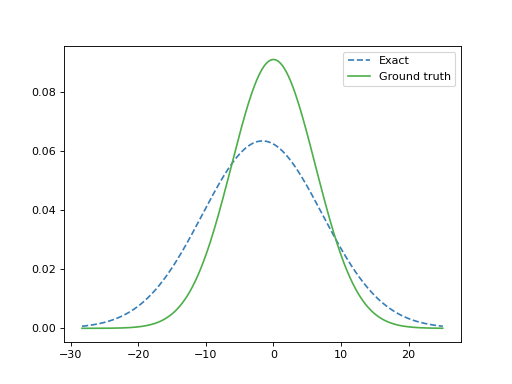

GridspecLayout(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='N', m…

In [7]:
def exact_solution(data, m0, v0, beta_mean0, beta_var0, iterations=10):
    N = len(data)
    s1 = np.sum(data)
    s2 = np.sum(np.square(data))
    xbar = np.mean(data)
    b0 = beta_var0/beta_mean0
    c0 = (beta_mean0**2)/beta_var0
    
    vN = v0 / (1 + N*v0)
    mN = ((m0/v0) + s1) * vN
    cN = c0 + (N/2)
    d = ((m0**2)/v0) - ((mN**2)/vN) + s2
    bN = 1 / ((1/b0) + d/2)
    beta_mean = bN * cN
    beta_var = (bN**2) * cN
    return mN, vN, beta_mean, beta_var

def update_exact_contour(change):
    ax3.clear()
    mE, vE, beta_meanE, beta_varE = exact_solution(w.value, m0.value, v0.value, beta_mean0.value, beta_var0.value)
    stdE = np.sqrt(1 / beta_meanE)
    xexact = np.linspace(mE - 3*stdE, mE + 3*stdE, 1000)
    exact_contour = get_contours(xexact, mE, stdE)
    data_contour = get_contours(xexact, mu.value, std.value)
    plot_contours(ax3,
                  (xexact, exact_contour, colours["exact"], "Exact", linestyles["exact"]),
                  (xexact, data_contour, colours["ground_truth"], "Ground truth", linestyles["ground_truth"]))

mE, vE, beta_meanE, beta_varE = exact_solution(w.value, m0.value, v0.value, beta_mean0.value, beta_var0.value)
stdE = np.sqrt(1 / beta_meanE)
xexact = np.linspace(mE - 3*stdE, mE + 3*stdE, 1000)
exact_contour = get_contours(xexact, mE, stdE)
data_contour = get_contours(xexact, mu.value, std.value)

fig3, ax3 = plt.subplots(num=30)
plot_contours(ax3,
              (xexact, exact_contour, colours["exact"], "Exact", linestyles["exact"]),
              (xexact, data_contour, colours["ground_truth"], "Ground truth", linestyles["ground_truth"]))

display(grid);

[w.children[n].observe(update_exact_contour, 'value') for n in range(len(w.children))];
[prior_widget.children[n].observe(update_exact_contour, 'value') for n in range(len(prior_widget.children))];

# Variational Bayes

<IPython.core.display.Javascript object>


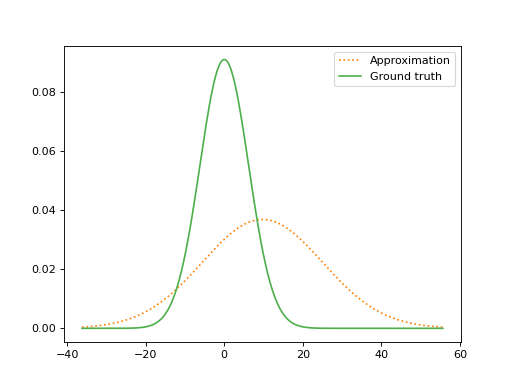

GridspecLayout(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='N', m…

In [10]:
def vb_solution(data, m0, v0, beta_mean0, beta_var0, iterations=100):
    N = len(data)
    s1 = np.sum(data)
    s2 = np.sum(np.square(data))
    b0 = beta_var0 / beta_mean0
    c0 = (beta_mean0**2)/beta_var0
    m, v, b, c = m0, v0, b0, c0
    for i in range(iterations):
        m = (m0 + v0 * b * c * s1) / (1 + N * v0 * b * c)
        v = v0 / (1 + N * v0 * b * c)
        x = s2 - 2*s1*m + N*(m**2 + v)
        b = 1 / (1/b0 + x/2)
        c = N/2 + c0
    beta_mean = b * c
    beta_var = (b**2) * c
    return m, v, beta_mean, beta_var

def update_vb_contour(change):
    ax4.clear()
    mVB, vVB, beta_meanVB, beta_varVB = vb_solution(w.value, m0.value, v0.value, beta_mean0.value, beta_var0.value)
    stdVB = np.sqrt(1 / beta_meanVB)
    xVB = np.linspace(mVB - 3*stdVB, mVB + 3*stdVB, 1000)
    vb_contour = get_contours(xVB, mVB, stdVB)
    data_contour = get_contours(xVB, mu.value, std.value)
    plot_contours(ax4,
                  (xVB, vb_contour, colours["approx"], "Approximation", linestyles["approx"]),
                  (xVB, data_contour, colours["ground_truth"], "Ground truth", linestyles["ground_truth"]))


mVB, vVB, beta_meanVB, beta_varVB = vb_solution(w.value, m0.value, v0.value, beta_mean0.value, beta_var0.value)
stdVB = np.sqrt(1 / beta_meanVB)
xVB = np.linspace(mVB - 3*stdVB, mVB + 3*stdVB, 1000)
vb_contour = get_contours(xVB, mVB, stdVB)
data_contour = get_contours(xVB, mu.value, std.value)

fig4, ax4 = plt.subplots(num=40)
plot_contours(ax4,
              (xVB, vb_contour, colours["approx"], "Approximation", linestyles["approx"]),
              (xVB, data_contour, colours["ground_truth"], "Ground truth", linestyles["ground_truth"]))

display(grid);

[w.children[n].observe(update_vb_contour, 'value') for n in range(len(w.children))];
[prior_widget.children[n].observe(update_vb_contour, 'value') for n in range(len(prior_widget.children))];

# How confident are we?

Above, we mentioned that an advantage of the Bayesian approach is that it gives you a measure of confidence in your predictions. This is in contrast to simply calculating the empirical mean and standard deviation. Let's see below how we can use this confidence.



<IPython.core.display.Javascript object>


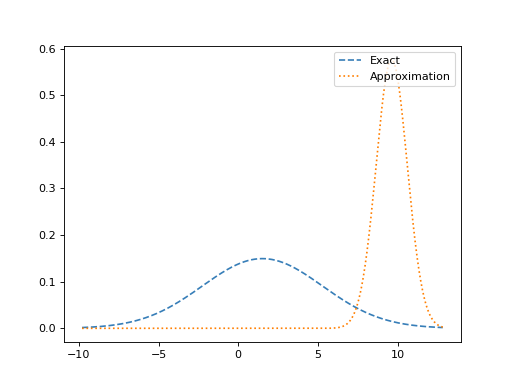

GridspecLayout(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='N', m…

In [11]:
def get_contour(x, mean, std):
    return (1 / (std * np.sqrt(np.pi))) * np.exp(-0.5 * np.square((x - mean) / std))

def plot_vb_and_exact_contours(ax):
    meanE, standard_devE = [], []
    meanVB, standard_devVB = [], []
    # average over 1000 runs
    for i in range(100):
        data = np.random.normal(mu.value, std.value, [N.value])

        # get exact and VB solutions
        mE, vE, beta_meanE, beta_varE = exact_solution(data, m0.value, v0.value, beta_mean0.value, beta_var0.value)
        mVB, vVB, beta_meanVB, beta_varVB = vb_solution(data, m0.value, v0.value, beta_mean0.value, beta_var0.value)
        bE = beta_varE / beta_meanE
        cE = (beta_meanE**2) / beta_varE
        stdE = np.sqrt(vE / (bE * (cE - 1)))
        stdVB = np.sqrt(vVB)
        
        # append to list
        meanE.append(mE)
        standard_devE.append(stdE)
        meanVB.append(mVB)
        standard_devVB.append(stdVB)
        
    # take mean across all runs
    mE, stdE = [np.mean(s) for s in (meanE, standard_devE)]
    mVB, stdVB = [np.mean(s) for s in (meanVB, standard_devVB)]
    
    # get range of points on x-axis
    xmin = np.min(((mE-3*stdE), (mVB-3*stdVB)))
    xmax = np.max(((mE+3*stdE), (mVB+3*stdVB)))
    x = np.linspace(xmin, xmax, 1000)
    
    # get contours
    yE = get_contour(x, mE, stdE)
    yVB = get_contour(x, mVB, stdVB)
    ydata = get_contour(x, mu.value, std.value)
    
    # plot
    plot_contours(ax5,
                  (x, yE, colours["exact"], "Exact", linestyles["exact"]),
                  (x, yVB, colours["approx"], "Approximation", linestyles["approx"]))

def update_contour_plot(change):
    ax5.clear()
    plot_vb_and_exact_contours(ax5)

fig5, ax5 = plt.subplots(num=5)
plot_vb_and_exact_contours(ax5)

display(grid);

[w.children[n].observe(update_contour_plot, 'value') for n in range(len(w.children))];
[prior_widget.children[n].observe(update_contour_plot, 'value') for n in range(len(prior_widget.children))];